In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, ADASYN
import dendropy
from sklearn.metrics import (
    roc_auc_score,
    RocCurveDisplay,
    classification_report,
    confusion_matrix,
    accuracy_score,
)
from data_augmentation.tada_sv import TADASV
from data_augmentation.no_tree_sv import NoTreeSV
from Bio import Phylo
from sklearn.metrics import matthews_corrcoef


In [24]:
# Data Loading
df = pd.read_csv("/Users/moritzgrunert/Desktop/Projects/2.Seminar/data_augmentation_microbiome/code/data/filtered_data.csv", index_col=0)
X = df.drop(columns=["diagnosis_binary"])
y = df["diagnosis_binary"]  

tree = dendropy.Tree.get(
    path="/Users/moritzgrunert/Desktop/Projects/2.Seminar/data_augmentation_microbiome/code/data/phylogeny_pruned.tre",   # dein geprunter Baum
    schema="newick",
    preserve_underscores=True,
    rooting="force-rooted",
)

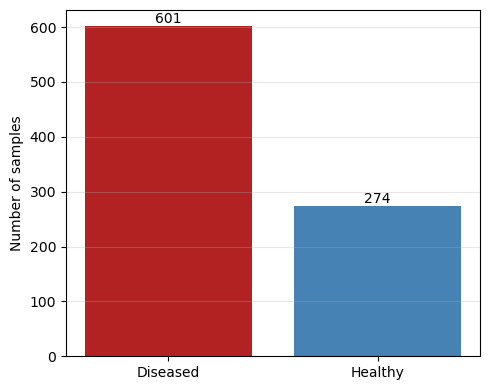

In [25]:

counts = y.value_counts().sort_index()

plt.figure(figsize=(5, 4))
bars = plt.bar(["Diseased", "Healthy"], counts.values, color=["firebrick", "steelblue"])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f"{int(height)}", ha="center", va="bottom")

plt.ylabel("Number of samples")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [26]:
# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [27]:
import numpy as np

def reduce_minority_class(X_train, y_train, r, seed=42):
    """
    Entfernt r Samples aus der Minority-Klasse (y == True) im Trainingsset.
    """
    rng = np.random.default_rng(seed)

    # Indizes der Minority-Klasse
    minority_idx = y_train[y_train == True].index.to_numpy()

    if r > len(minority_idx):
        raise ValueError(
            f"r={r} is larger than number of minority samples ({len(minority_idx)})"
        )

    # zufällige Auswahl der zu entfernenden Samples
    remove_idx = rng.choice(minority_idx, size=r, replace=False)

    # neue Trainingsdaten
    X_reduced = X_train.drop(index=remove_idx)
    y_reduced = y_train.drop(index=remove_idx)

    return X_reduced, y_reduced

In [28]:
X_train, y_train = reduce_minority_class(
    X_train, y_train, r=194, seed=42
)

In [29]:
distribution = []
distribution.append(y_train.value_counts().to_dict())

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)
distribution.append(y_train_SMOTE.value_counts().to_dict())

"""
# SMOTE on log-transformed data
X_train_log = np.log1p(X_train) # Log-transform the data
X_test_log = np.log1p(X_test)   # Log-transform the data
smote = SMOTE(random_state=42)  
X_train_SMOTE_log , y_train_SMOTE_log = smote.fit_resample(X_train_log, y_train)
distribution.append(y_train_SMOTE_log.value_counts().to_dict())
"""

#ADASYN
adasyn = ADASYN(random_state=42)
X_train_ADASYN, y_train_ADASYN = adasyn.fit_resample(X_train, y_train) 
distribution.append(y_train_ADASYN.value_counts().to_dict())


# TADA-SV
tada_sv = TADASV(tree=tree, k=5, random_state=42)
X_train_TADA_SV_5, y_train_TADA_SV_5 = tada_sv.fit_resample(X_train, y_train) 
distribution.append(y_train_TADA_SV_5.value_counts().to_dict())


"""
# TADA-SV 50
tada_sv = TADASV(tree=tree, k=50, random_state=42)
X_train_TADA_SV_50, y_train_TADA_SV_50 = tada_sv.fit_resample(X_train, y_train) 
print(f"TADA-SV_50 shape: {X_train_TADA_SV_50.shape}")
print(y_train_TADA_SV_50.value_counts())
print("-----")  
"""

# TADA-SV balance
tada_sv = TADASV(tree=tree, random_state=42, sampling_strategy="balance")
X_train_TADA_SV_ba, y_train_TADA_SV_ba = tada_sv.fit_resample(X_train, y_train) 
distribution.append(y_train_TADA_SV_ba.value_counts().to_dict())

# TADA-SV balance ++
tada_sv = TADASV(tree=tree, q=2, random_state=42, sampling_strategy="balance++")
X_train_TADA_SV_ba_plus, y_train_TADA_SV_ba_plus = tada_sv.fit_resample(X_train, y_train) 
distribution.append(y_train_TADA_SV_ba_plus.value_counts().to_dict())

# NoTreeSV
no_tree = NoTreeSV(k=5, random_state=42, sampling_strategy="auto", smoothing=1.0)
X_train_NoTreeSV_5, y_train_NoTreeSV_5 = no_tree.fit_resample(X_train, y_train) 
distribution.append(y_train_NoTreeSV_5.value_counts().to_dict())

# NoTreeSV balance
aug = NoTreeSV(random_state=42, sampling_strategy="balance", smoothing=1.0)
X_train_NoTreeSV_bal, y_train_NoTreeSV_bal = aug.fit_resample(X_train, y_train) 
distribution.append(y_train_NoTreeSV_bal.value_counts().to_dict())
 
# NoTreeSV balance++
aug = NoTreeSV(random_state=42, sampling_strategy="balance++", q=2, smoothing=1.0)
X_train_NoTreeSV_bal_plus, y_train_NoTreeSV_bal_plus = aug.fit_resample(X_train, y_train)
distribution.append(y_train_NoTreeSV_bal_plus.value_counts().to_dict()) 

distribution.append(y_test.value_counts().to_dict())

# Deine Daten
data = distribution

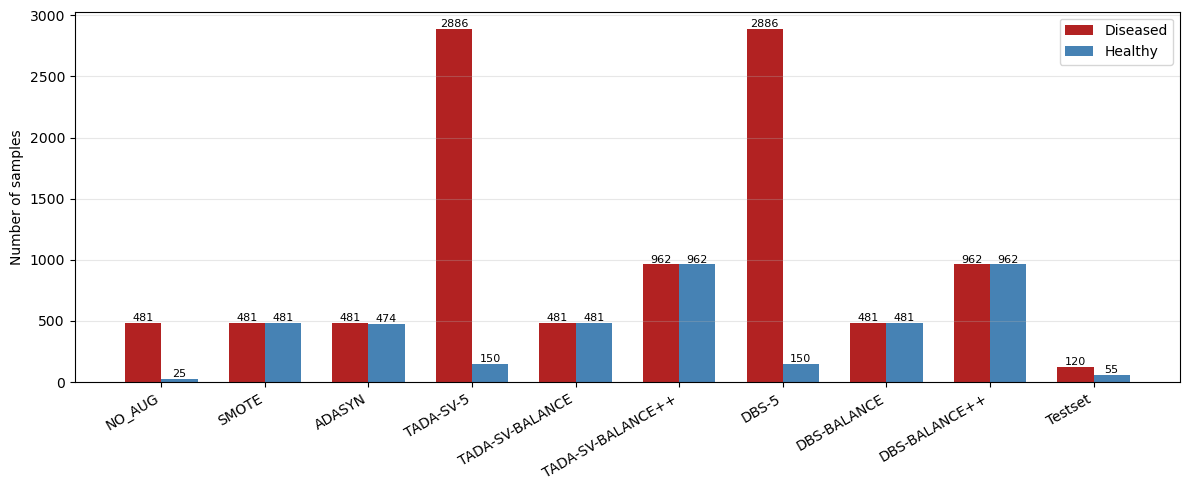

In [30]:

labels = [
    "NO_AUG", "SMOTE", "ADASYN",
    "TADA-SV-5", "TADA-SV-BALANCE", "TADA-SV-BALANCE++",
    "DBS-5", "DBS-BALANCE", "DBS-BALANCE++", "Testset"
]

# Werte extrahieren
healthy = [d[True] for d in data]
diseased = [d[False] for d in data]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(12, 5))

bars1 = plt.bar(x - width/2, diseased, width,
                label="Diseased", color="firebrick")
bars2 = plt.bar(x + width/2, healthy, width,
                label="Healthy", color="steelblue")

# Zahlen über Balken
for bars in (bars1, bars2):
    for bar in bars:
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, h,
                 f"{int(h)}", ha="center", va="bottom", fontsize=8)

plt.xticks(x, labels, rotation=30, ha="right")
plt.ylabel("Number of samples")
plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()
 

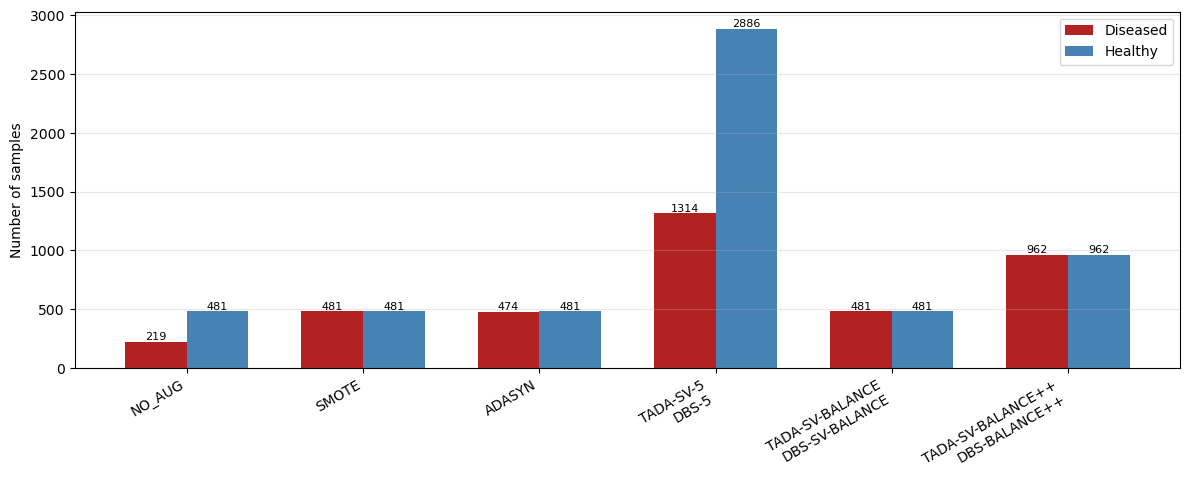

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Deine Daten
data = [
    {False: 481, True: 219},
    {False: 481, True: 481},
    {False: 481, True: 474},
    {False: 2886, True: 1314},
    {False: 481, True: 481},
    {False: 962, True: 962},
]

labels = [
    "NO_AUG", "SMOTE", "ADASYN",
    f"TADA-SV-5\nDBS-5", "TADA-SV-BALANCE\nDBS-SV-BALANCE", "TADA-SV-BALANCE++\nDBS-BALANCE++",
]

# Werte extrahieren
healthy = [d[False] for d in data]
diseased = [d[True] for d in data]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(12, 5))

bars1 = plt.bar(x - width/2, diseased, width,
                label="Diseased", color="firebrick")
bars2 = plt.bar(x + width/2, healthy, width,
                label="Healthy", color="steelblue")

# Zahlen über Balken
for bars in (bars1, bars2):
    for bar in bars:
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, h,
                 f"{int(h)}", ha="center", va="bottom", fontsize=8)

plt.xticks(x, labels, rotation=30, ha="right")
plt.ylabel("Number of samples")
plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
def RF(X_train, y_train, X_test, random_state=42):
    clf = RandomForestClassifier(
    n_estimators=2000,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced",
)
    clf.fit(X_train, y_train)  # Training
    y_pred = clf.predict(X_test)    # Predictions
    y_proba = clf.predict_proba(X_test)[:, 1] # Probabilities for ROC-AUC
    return y_pred, y_proba

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, matthews_corrcoef

methods = [
    ("NO_AUG", X_train, y_train, X_test, y_test),
    ("SMOTE", X_train_SMOTE, y_train_SMOTE, X_test, y_test),
    #("SMOTElog1p", X_train_SMOTE_log, y_train_SMOTE_log, X_test_log, y_test),
    ("ADASYN", X_train_ADASYN, y_train_ADASYN, X_test, y_test),
    ("TADASV_5", X_train_TADA_SV_5, y_train_TADA_SV_5, X_test, y_test),
    ("TADASV_50", X_train_TADA_SV_5, y_train_TADA_SV_5, X_test, y_test), #dummy
    ("TADASV_BALANCE", X_train_TADA_SV_ba, y_train_TADA_SV_ba, X_test, y_test),
    ("TADASV_BALANCE++", X_train_TADA_SV_ba_plus, y_train_TADA_SV_ba_plus, X_test, y_test),
    ("NO_TREESV_5", X_train_NoTreeSV_5, y_train_NoTreeSV_5, X_test, y_test),
    ("NO_TREESV_BALANCE", X_train_NoTreeSV_bal, y_train_NoTreeSV_bal, X_test, y_test),
    ("NO_TREESV_BALANCE++", X_train_NoTreeSV_bal_plus, y_train_NoTreeSV_bal_plus, X_test, y_test),
]

rows = []
n_reps = 1

for i in range(n_reps):
    print("Iteration:", i)

    for name, Xtr, ytr, Xte, yte in methods:
        y_pred, y_proba = RF(Xtr, ytr, Xte, i)

        rows.append({
            "rep": i,
            "method": name,
            "accuracy": accuracy_score(yte, y_pred),
            "auc": roc_auc_score(yte, y_proba),
            "mcc": matthews_corrcoef(yte, y_pred),
        })

results = pd.DataFrame(rows)
results.head()

Iteration: 0
Iteration: 1


,rep,method,accuracy,auc,mcc
0,0,NO_AUG,0.731429,0.830606,0.300212
1,0,SMOTE,0.765714,0.811515,0.419673
2,0,SMOTElog1p,0.742857,0.831667,0.352001
3,0,ADASYN,0.742857,0.807652,0.359963
4,0,TADASV_5,0.760000,0.850909,0.392422


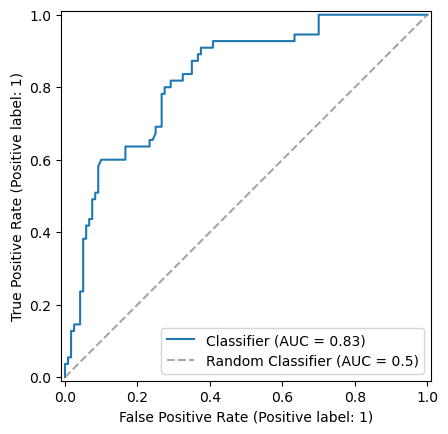

In [79]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

auc = roc_auc_score(y_test, y_proba)

RocCurveDisplay.from_predictions(
    y_test,
    y_proba,
)

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.7, label="Random Classifier (AUC = 0.5)")
#plt.title(f"ROC Curve (AUC = {auc:.3f})")
plt.legend()
plt.show()

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def barplot_mean_se(
    results: pd.DataFrame,
    metric: str = "auc",
    order=None,
    title=None,
    ylim=[0.0, 1.0]
):
    if metric not in results.columns:
        raise ValueError(f"metric '{metric}' not in results columns: {results.columns.tolist()}")

    # mean & standard error
    stats = (
        results.groupby("method")[metric]
        .agg(["mean", "std", "count"])
        .rename(columns={"count": "n"})
    )
    stats["se"] = stats["std"] / np.sqrt(stats["n"])

    if order is not None:
        stats = stats.loc[order]

    # ----------------------------
    # Farbzuordnung
    # ----------------------------
    def method_color(name: str):
        if name == "NO_AUG":
            return "#7F7F7F"      # grau
        elif name in ["SMOTE", "ADASYN"]:
            return "#E69F00"      # orange
        elif name.startswith("TADA"):
            return "#CC79A7"      # violett
        elif name.startswith("DBS"):
            return "#009E73"      # grün
        else:
            return "#999999"      # fallback

    colors = [method_color(m) for m in stats.index]

    # ----------------------------
    # Plot
    # ----------------------------
    x = np.arange(len(stats))
    fig, ax = plt.subplots(figsize=(max(10, 0.6 * len(stats)), 4))

    ax.bar(
        x,
        stats["mean"].values,
        yerr=stats["se"].values,
        capsize=5,
        color=colors,
        edgecolor="black",
        linewidth=0.6
    )

    ax.set_xticks(x)
    ax.set_xticklabels(stats.index, rotation=35, ha="right")
    ax.set_ylabel(metric.upper())
    ax.set_title(title or f"{metric.upper()} (mean ± SE)")
    ax.grid(axis="y", alpha=0.3)
    ax.set_ylim(ylim)
    from matplotlib.patches import Patch

    """legend_elements = [
        Patch(facecolor="#7F7F7F", label="No augmentation"),
        Patch(facecolor="#E69F00", label="SMOTE / ADASYN"),
        Patch(facecolor="#CC79A7", label="TADA-SV"),
        Patch(facecolor="#009E73", label="DBS"),
        ]

    ax.legend(handles=legend_elements, frameon=False)"""
    

    plt.tight_layout()
    plt.show()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def boxplot_metric(
    results: pd.DataFrame,
    metric: str = "auc",
    order=None,
    title=None,
    ylim=[0.0, 1.0]
):
    if metric not in results.columns:
        raise ValueError(f"metric '{metric}' not in results columns")

    if order is None:
        order = sorted(results["method"].unique())

    # ----------------------------
    # Daten sammeln
    # ----------------------------
    data = [results.loc[results["method"] == m, metric].values for m in order]

    # ----------------------------
    # Farbzuordnung (wie zuvor)
    # ----------------------------
    def method_color(name: str):
        if name == "NO_AUG":
            return "#7F7F7F"      # grau
        elif name in ["SMOTE", "ADASYN"]:
            return "#E69F00"      # orange
        elif name.startswith("TADA"):
            return "#CC79A7"      # violett
        elif name.startswith("DBS"):
            return "#009E73"      # grün
        else:
            return "#999999"

    colors = [method_color(m) for m in order]

    # ----------------------------
    # Plot
    # ----------------------------
    fig, ax = plt.subplots(figsize=(max(10, 0.6 * len(order)), 4))

    bp = ax.boxplot(
        data,
        patch_artist=True,
        widths=0.6,
        showfliers=True
    )

    # Farben setzen
    for patch, color in zip(bp["boxes"], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor("black")
        patch.set_alpha(0.85)

    for element in ["whiskers", "caps", "medians"]:
        for item in bp[element]:
            item.set_color("black")

    ax.set_xticks(np.arange(1, len(order) + 1))
    ax.set_xticklabels(order, rotation=35, ha="right")
    ax.set_ylabel(metric.upper())
    ax.set_title(title or f"{metric.upper()} distribution across runs")
    ax.set_ylim(ylim)
    ax.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()

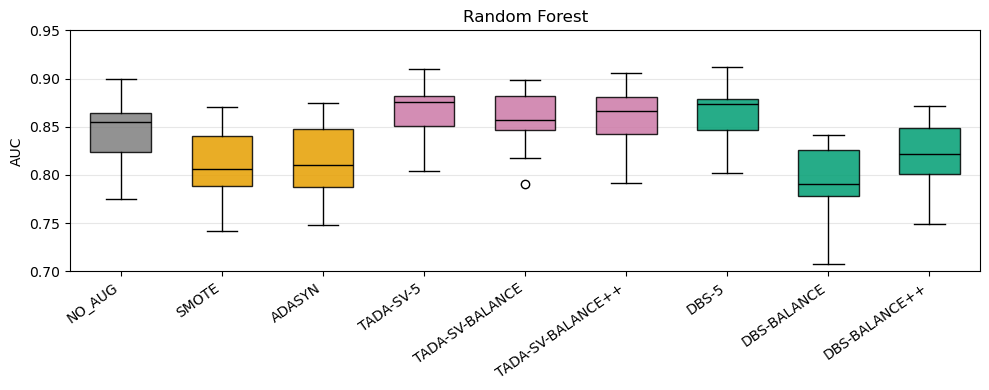

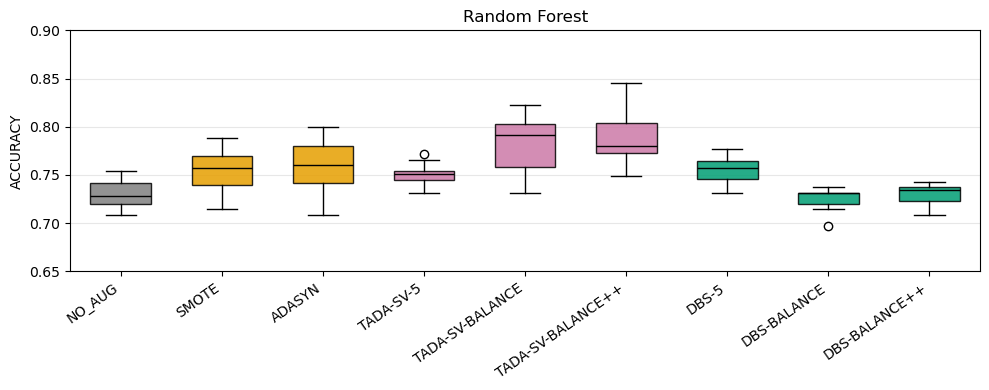

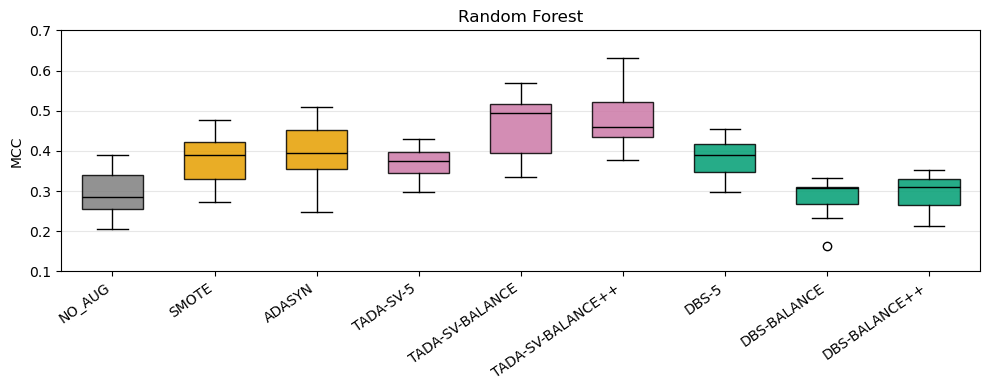

In [36]:
results = csv_results = pd.read_csv("/Users/moritzgrunert/Desktop/Projects/2.Seminar/data_augmentation_microbiome/code/results/e2_rf_1_3_results.csv")
order = [
    "NO_AUG", "SMOTE", "ADASYN",
    "TADA-SV-5", "TADA-SV-BALANCE", "TADA-SV-BALANCE++",
    "DBS-5", "DBS-BALANCE", "DBS-BALANCE++"
]


for met, lim in [["auc", [0.7, 0.95]], ["accuracy", [0.65, 0.90]], ["mcc", [0.1, 0.7]]]:
    boxplot_metric(
        results,
        metric=met,
        order=[
            "NO_AUG", "SMOTE", "ADASYN",
            "TADA-SV-5", "TADA-SV-BALANCE", "TADA-SV-BALANCE++",
            "DBS-5", "DBS-BALANCE", "DBS-BALANCE++"
        ],
        title="Random Forest",
        ylim=lim
    )

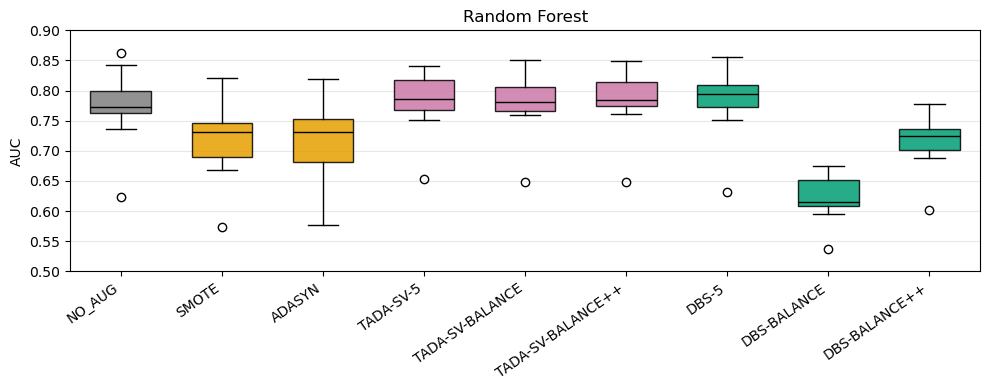

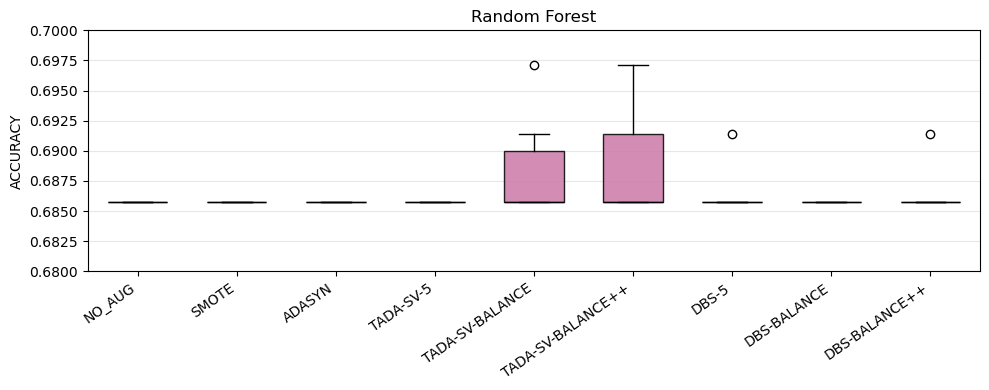

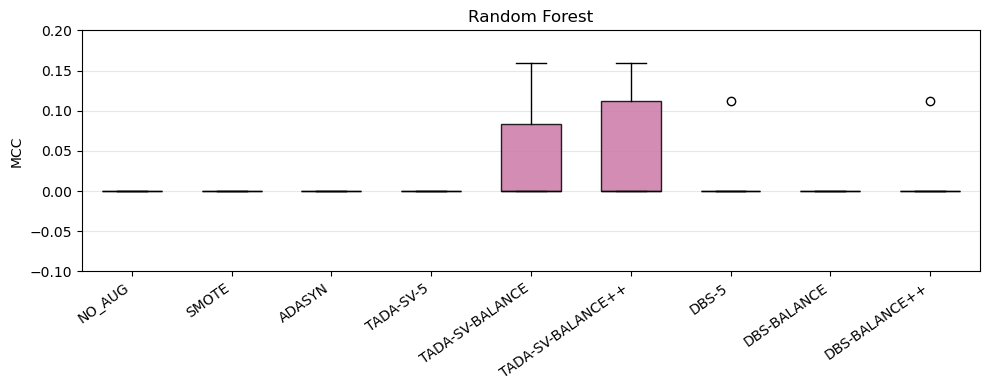

In [60]:
results = csv_results = pd.read_csv("/Users/moritzgrunert/Desktop/Projects/2.Seminar/data_augmentation_microbiome/code/results/e2_rf_1_6_results.csv")
order = [
    "NO_AUG", "SMOTE", "ADASYN",
    "TADA-SV-5", "TADA-SV-BALANCE", "TADA-SV-BALANCE++",
    "DBS-5", "DBS-BALANCE", "DBS-BALANCE++"
]


for met, lim in [["auc", [0.5, 0.90]], ["accuracy", [0.68, 0.70]], ["mcc", [-0.1, 0.2]]]:
    boxplot_metric(
        results,
        metric=met,
        order=[
            "NO_AUG", "SMOTE", "ADASYN",
            "TADA-SV-5", "TADA-SV-BALANCE", "TADA-SV-BALANCE++",
            "DBS-5", "DBS-BALANCE", "DBS-BALANCE++"
        ],
        title="Random Forest",
        ylim=lim
    )

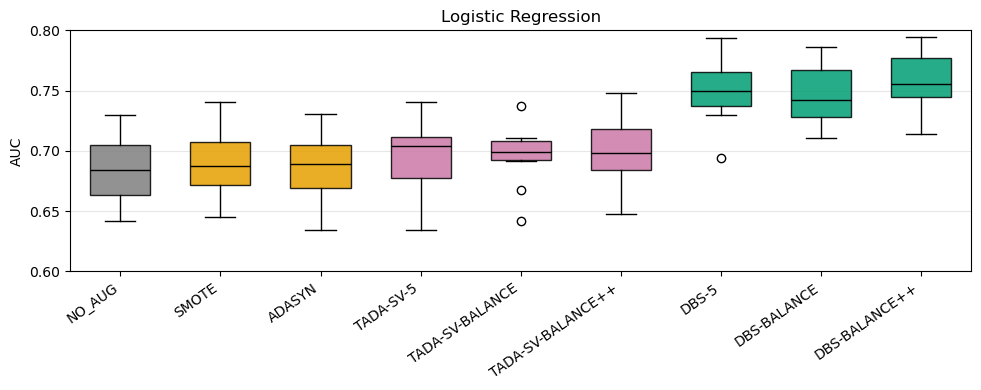

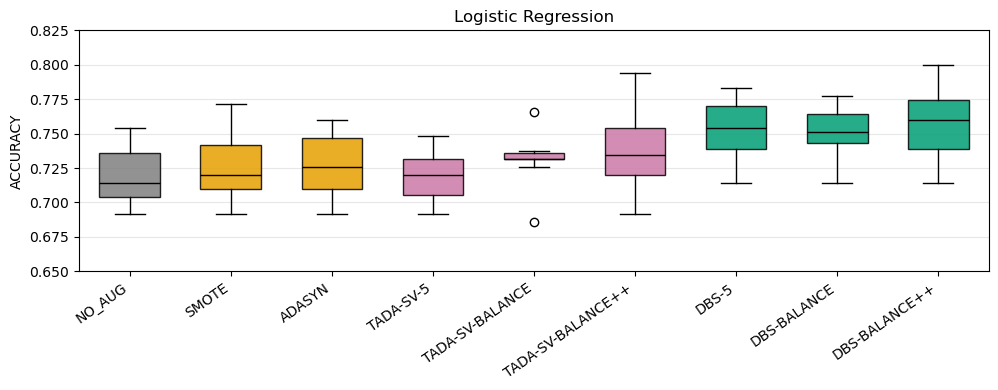

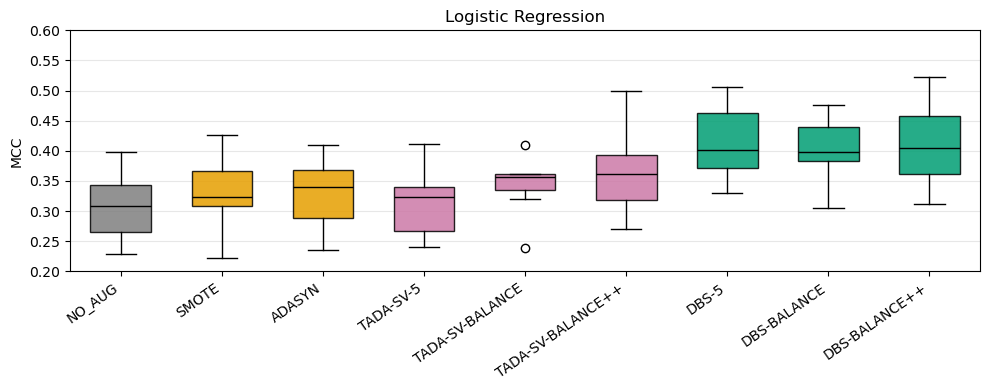

In [58]:
results = csv_results = pd.read_csv("/Users/moritzgrunert/Desktop/Projects/2.Seminar/data_augmentation_microbiome/code/results/e2_lr_1_3_results.csv")
order = [
    "NO_AUG", "SMOTE", "ADASYN",
    "TADA-SV-5", "TADA-SV-BALANCE", "TADA-SV-BALANCE++",
    "DBS-5", "DBS-BALANCE", "DBS-BALANCE++"
]


for met, lim in [["auc", [0.60, 0.8]], ["accuracy", [0.65, 0.825]], ["mcc", [0.2, 0.6]]]:
    boxplot_metric(
        results,
        metric=met,
        order=[
            "NO_AUG", "SMOTE", "ADASYN",
            "TADA-SV-5", "TADA-SV-BALANCE", "TADA-SV-BALANCE++",
            "DBS-5", "DBS-BALANCE", "DBS-BALANCE++"
        ],
        title="Logistic Regression",
        ylim=lim
    )

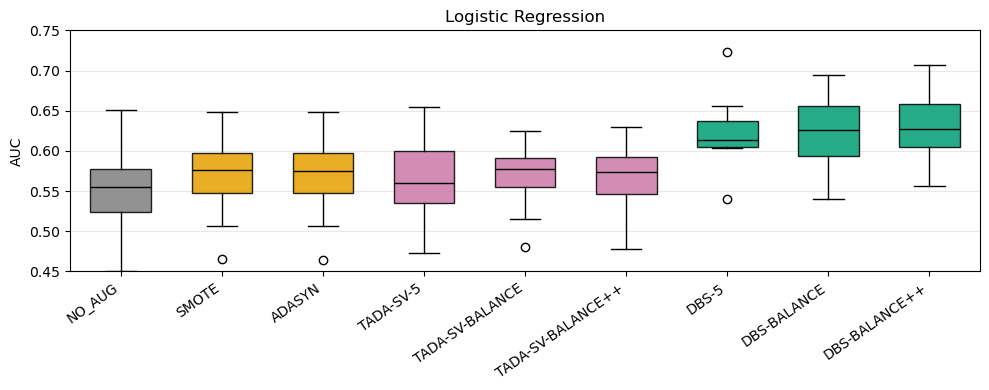

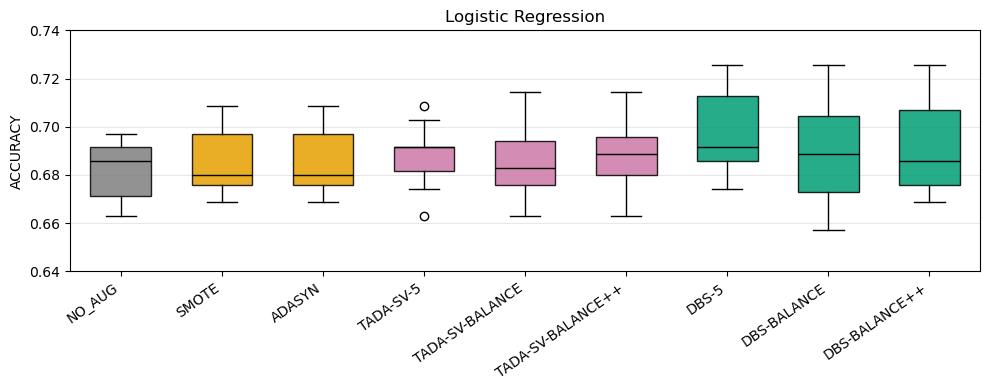

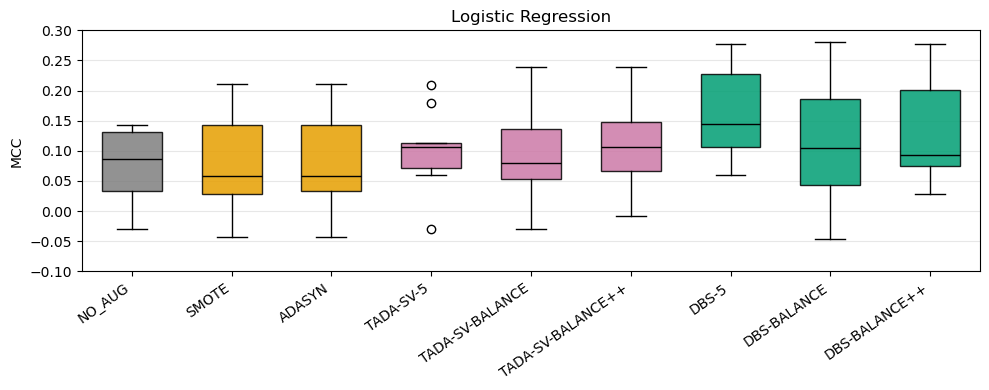

In [59]:
results = csv_results = pd.read_csv("/Users/moritzgrunert/Desktop/Projects/2.Seminar/data_augmentation_microbiome/code/results/e2_lr_1_6_results.csv")
order = [
    "NO_AUG", "SMOTE", "ADASYN",
    "TADA-SV-5", "TADA-SV-BALANCE", "TADA-SV-BALANCE++",
    "DBS-5", "DBS-BALANCE", "DBS-BALANCE++"
]


for met, lim in [["auc", [0.45, 0.75]], ["accuracy", [0.64, 0.74]], ["mcc", [-0.1, 0.3]]]:
    boxplot_metric(
        results,
        metric=met,
        order=[
            "NO_AUG", "SMOTE", "ADASYN",
            "TADA-SV-5", "TADA-SV-BALANCE", "TADA-SV-BALANCE++",
            "DBS-5", "DBS-BALANCE", "DBS-BALANCE++"
        ],
        title="Logistic Regression",
        ylim=lim
    )